# Ensemble modelling
Compare previously developed binary NLP classifier with an ensemble model that combines predicted probabilities with demographocs and details about arrival to ED.

In [1]:
import pandas as pd
import numpy as np
from time import time
import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.compose import make_column_transformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

from sklearn.metrics import make_scorer, average_precision_score, precision_recall_curve

import utils

import matplotlib.pyplot as plt
import seaborn as sns

# Pretty plots
%matplotlib inline
plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Display wide columns
pd.options.display.max_columns = 100

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vrozova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
filename = "rmh_1217_train"
filename2 = "rmh_1217_test"

class_names = ("Controls", "Self-harm")

### Load training data

In [3]:
df_train = pd.read_csv("../data/" + filename + "_raw.csv")
print(df_train.shape)

y_train = df_train.SH.values
df_train.SH.value_counts()

(316959, 11)


0    312613
1      4346
Name: SH, dtype: int64

In [4]:
y_proba = pd.read_csv("../data/" + filename + "_cv_proba.csv")
df_train = df_train.merge(y_proba)

In [5]:
y_proba_nlp = np.stack((1 - y_proba.y_proba, y_proba.y_proba), axis=1)

___
# Additional features
### Arrival date

In [6]:
# Convert to datetime
df_train.arrival_date = pd.to_datetime(df_train.arrival_date, dayfirst=True)
print("Arrival date:", df_train.arrival_date.min(), df_train.arrival_date.max())

Arrival date: 2012-01-08 00:35:00 2017-12-31 23:55:00


In [7]:
df_train[['year', 'week', 'day_of_week']] = df_train.arrival_date.dt.isocalendar()

In [8]:
df_train['month'] = df_train.arrival_date.dt.month.astype(int)
df_train['hour'] = df_train.arrival_date.dt.hour.astype(int)
df_train['is_leap_year'] = df_train.arrival_date.dt.is_leap_year.astype(int)
df_train['is_year_start'] = df_train.arrival_date.dt.is_year_start.astype(int)
df_train['is_year_end'] = df_train.arrival_date.dt.is_year_end.astype(int)
df_train['is_quarter_start'] = df_train.arrival_date.dt.is_quarter_start.astype(int)
df_train['is_quarter_end'] = df_train.arrival_date.dt.is_quarter_end.astype(int)
df_train['is_month_start'] = df_train.arrival_date.dt.is_month_start.astype(int)
df_train['is_month_end'] = df_train.arrival_date.dt.is_month_end.astype(int)

In [9]:
df_train['time_of_day'] = "night"
df_train.loc[df_train.hour >= 6, 'time_of_day'] = "morning"
df_train.loc[df_train.hour >= 12, 'time_of_day'] = "day"
df_train.loc[df_train.hour >= 18, 'time_of_day'] = "evening"

In [10]:
df_train.head()

,patient_id,uid,age,sex,arrival_mode,arrival_date,year,text,length,SH,SI,y_proba,week,day_of_week,month,hour,is_leap_year,is_year_start,is_year_end,is_quarter_start,is_quarter_end,is_month_start,is_month_end,time_of_day
0,832187.0,521240,73,male,road ambulance,2012-06-08 17:40:00,2012,"? cva, aphasic, r side weakness, seen well 163...",95,0,0,0.000032,23,5,6,17,1,0,0,0,0,0,0,day
1,2290504.0,247506,69,female,self/community/pt,2016-05-01 09:00:00,2016,"Fall onto right elbow 3/7 ago, increased pain ...",120,0,0,0.000000,17,7,5,9,1,0,0,0,0,1,0,morning
2,2269705.0,972276,23,male,road ambulance,2015-11-30 14:45:00,2015,Section 351: Found by police behaving erractic...,154,1,0,0.097477,49,1,11,14,0,0,0,0,0,0,1,day
3,2227481.0,347129,47,female,air ambulance,2015-01-01 15:12:00,2015,Came off boogie board-headstrike to sandbar. L...,140,0,0,0.002010,1,4,1,15,0,1,0,1,0,1,0,day
4,2118001.0,177348,41,female,other,2013-03-23 11:06:00,2013,bilateral flank pain since 1/24 ago while on f...,88,0,0,0.000025,12,6,3,11,0,0,0,0,0,0,0,morning


In [11]:
# Plot the number of presentations per day
x_time = pd.date_range(start=df_train.arrival_date.dt.date.min(), 
                       end=df_train.arrival_date.dt.date.max())
y_count = pd.Series(0, index=x_time)
y_count[df_train.arrival_date.dt.date.unique()] = df_train.groupby(df_train.arrival_date.dt.date).size()
y_count

2012-01-08    135
2012-01-09    127
2012-01-10    143
2012-01-11    105
2012-01-12    100
             ... 
2017-12-27    180
2017-12-28    186
2017-12-29    166
2017-12-30    176
2017-12-31    141
Freq: D, Length: 2185, dtype: int64

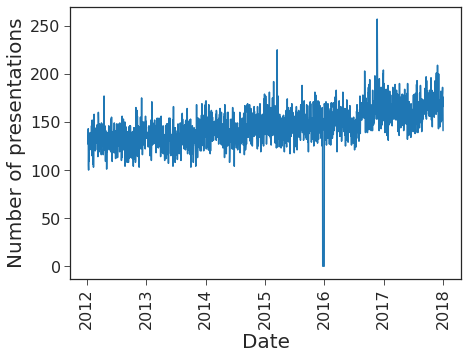

In [12]:
# plt.rcParams['figure.figsize'] = (15, 10)
sns.lineplot(x=x_time, y=y_count);
plt.xlabel("Date");
plt.ylabel("Number of presentations");
plt.xticks(rotation=90);
# plt.savefig("../results/number of presentations 1217.jpeg", bbox_inches='tight', dpi=300, pad_inches=0);

___
# Model development
### Numeric features 

In [13]:
features = ['age', 'sex', 'arrival_mode', 
            'year', 'week', 'day_of_week', 
            'month', 'hour', 
            'is_leap_year', 
            'is_year_start', 'is_year_end',
            'is_quarter_start', 'is_quarter_end', 
            'is_month_start', 'is_month_end',
            'time_of_day']
num_features = ['age', 'year', 'week', 'day_of_week', 'month', 'hour']
cat_features = [ft for ft in features if ft not in num_features]
len(features), len(num_features), len(cat_features)

(16, 6, 10)

In [ ]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), cat_features), 
    remainder='passthrough'
)

transformer.fit(df_train[features])
transformer.get_feature_names()

In [17]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['sex', 'arrival_mode']), 
    (StandardScaler(), ['age']), 
    remainder='passthrough'
)

clfs = (
#     MultinomialNB(),
    LogisticRegression(class_weight="balanced"),
#     LogisticRegression(class_weight="balanced", fit_intercept=False),
#     DecisionTreeClassifier(class_weight="balanced"),
#     RandomForestClassifier(class_weight="balanced")
)

In [18]:
%%time
for clf in clfs:
    pipe = make_pipeline(transformer, clf)
    scores = utils.benchmark_cv_score(pipe, df_train[['age','sex', 'arrival_mode']], y_train, class_names)

________________________________________________________________________________

Model training: 
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'arrival_mode']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])
train time: 12.868s
Average Precision: 0.043 (+/- 0.00)
Average Recall: 0.742 (+/- 0.05)
Average F1 score: 0.080 (+/- 0.01)
Average AP score: 0.065 (+/- 0.01)
CPU times: user 316 ms, sys: 14 ms, total: 330 ms
Wall time: 12.9 s


### Stacking predicted probabilities from two classifiers

In [14]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['sex', 'arrival_mode']), 
    (StandardScaler(), ['age']), 
    remainder='passthrough'
)
clf = LogisticRegression(class_weight="balanced")
pipe = make_pipeline(transformer, clf)

y_proba_num = utils.benchmark_cv(pipe, df_train[['age','sex', 'arrival_mode']], y_train, class_names)

________________________________________________________________________________

Model training: 
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'arrival_mode']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])
train time: 23.133s


In [15]:
scaler = StandardScaler()
clfs = (
    LogisticRegression(class_weight="balanced"),
    LogisticRegression(class_weight="balanced", fit_intercept=False),
    DecisionTreeClassifier(class_weight="balanced"),
)

In [16]:
%%time
for clf in clfs:
    pipe = make_pipeline(scaler, clf)
    scores = utils.benchmark_cv_score(pipe, 
                                      np.stack((y_proba_nlp[:,1], y_proba_num[:,1]), axis=1), 
                                      y_train, class_names)

________________________________________________________________________________

Model training: 
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])
train time: 4.027s
Average Precision: 0.505 (+/- 0.02)
Average Recall: 0.908 (+/- 0.03)
Average F1 score: 0.648 (+/- 0.02)
Average AP score: 0.846 (+/- 0.03)
________________________________________________________________________________

Model training: 
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    fit_intercept=False))])
train time: 2.705s
Average Precision: 0.266 (+/- 0.01)
Average Recall: 0.959 (+/- 0.02)
Average F1 score: 0.417 (+/- 0.02)
Average AP score: 0.852 (+/- 0.02)
________________________________________________________________________________

Model training: 
Pipeline(steps=[

In [26]:
scaler = StandardScaler()
clf = LogisticRegression(class_weight="balanced", fit_intercept=False)
pipe = make_pipeline(scaler, clf)

y_proba_stack = utils.benchmark_cv(pipe, 
                                   np.stack((y_proba_nlp[:,1], y_proba_num[:,1]), axis=1), 
                                   y_train, class_names)
thresh = utils.select_threshold(y_train, y_proba_stack)

________________________________________________________________________________

Model training: 
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced',
                                    fit_intercept=False))])
train time: 4.844s
Best threshold is 1.000, F1 score=0.792


Model evaluation on the train 2012-2017 set

Classification report:
              precision    recall  f1-score   support

           0      0.997     0.998     0.997    312613
           1      0.825     0.761     0.792      4346

    accuracy                          0.995    316959
   macro avg      0.911     0.879     0.894    316959
weighted avg      0.994     0.995     0.994    316959

binary F2: 0.773
Average precision score: 0.784


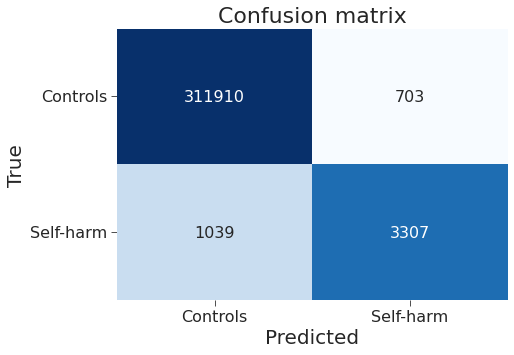

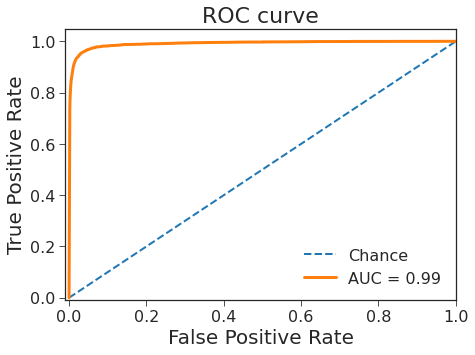

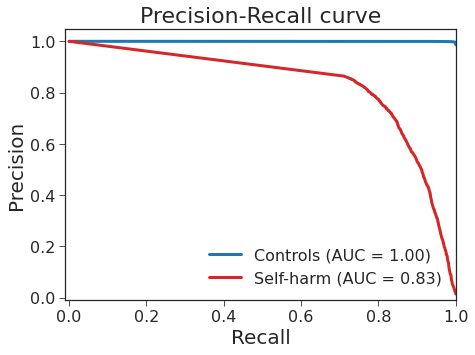

In [27]:
y_pred = utils.evaluate_model(y_train, y_proba_stack, class_names, "train 2012-2017", thresh=thresh, digits=3, 
                              save_figures=False, filename="../results/" + filename2)

Model evaluation on the train 2012-2017 set

Classification report:
              precision    recall  f1-score   support

           0      0.997     0.998     0.997    312613
           1      0.820     0.765     0.791      4346

    accuracy                          0.994    316959
   macro avg      0.909     0.881     0.894    316959
weighted avg      0.994     0.994     0.994    316959

binary F2: 0.775
Average precision score: 0.852


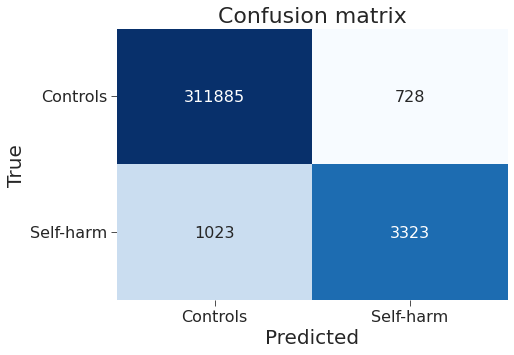

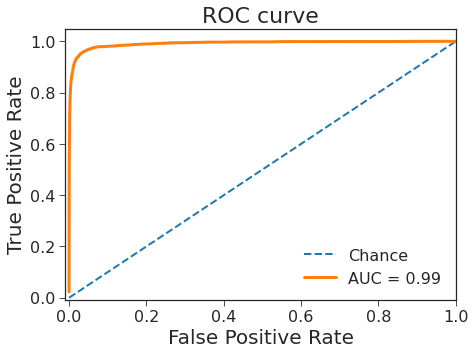

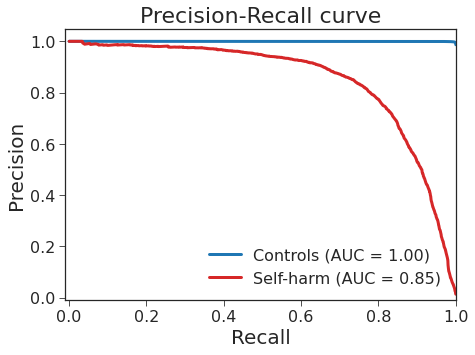

In [28]:
y_pred = utils.evaluate_model(y_train, y_proba_nlp, class_names, "train 2012-2017", thresh=0.390, digits=3, 
                              save_figures=False, filename="../results/" + filename2)

### Stacking NLP probabilities and additional features

In [23]:
# transformer = make_column_transformer(
#     (OneHotEncoder(drop='if_binary'), cat_features), 
#     (StandardScaler(), num_features + ['y_proba']), 
#     remainder='passthrough'
# )
transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['sex', 'arrival_mode']), 
    (StandardScaler(), ['age']), 
    remainder='passthrough'
)

clfs = (
#     MultinomialNB(),
    LogisticRegression(class_weight="balanced"),
    LogisticRegression(class_weight="balanced", fit_intercept=False),
#     DecisionTreeClassifier(class_weight="balanced"),
#     RandomForestClassifier(class_weight="balanced")
)

In [25]:
%%time
for clf in clfs:
    pipe = make_pipeline(transformer, clf)
    scores = utils.benchmark_cv_score(pipe, 
#                                       df_train[features + ['y_proba']], 
                                      df_train[['age','sex', 'arrival_mode', 'y_proba']],
                                      y_train, class_names)

________________________________________________________________________________

Model training: 
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sex', 'arrival_mode']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])
train time: 20.010s
Average Precision: 0.506 (+/- 0.02)
Average Recall: 0.907 (+/- 0.02)
Average F1 score: 0.650 (+/- 0.02)
Average AP score: 0.847 (+/- 0.03)
________________________________________________________________________________

Model training: 
Pipeline(steps=[(

### Max voting with probabilities

In [ ]:
y_proba_max = np.max([y_proba_nlp[:,1], y_proba_num[:,1]], axis=0)
y_proba_max = np.stack((1 - y_proba_max, y_proba_max), axis=1)

thresh = utils.select_threshold(y_train, y_proba_max)

### Averaging probabilities

In [ ]:
y_proba_avg = np.mean([y_proba_nlp[:,1], y_proba_num[:,1]], axis=0)
y_proba_avg = np.stack((1 - y_proba_avg, y_proba_avg), axis=1)

thresh = utils.select_threshold(y_train, y_proba_avg)

### Averaging NLP probabilities and predictions based on additional features

In [ ]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['sex', 'arrival_mode', 'time_of_day']), 
    remainder='passthrough'
)

clf = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight="balanced")

pipe = make_pipeline(transformer, clf)

y_proba = utils.benchmark_cv(pipe, df_train[features], y_train, class_names)

In [ ]:
y_proba_avg = np.mean([df_train.y_proba, y_proba[:,1]], axis=0)
y_proba_avg = np.stack((1 - y_proba_avg, y_proba_avg), axis=1)

In [ ]:
thresh = utils.select_threshold(y_train, y_proba_avg)

In [ ]:
y_pred = utils.evaluate_model(y_train, y_proba_avg, class_names, "train 2012-2017", thresh=thresh, digits=3, 
                              save_figures=False, filename="../results/" + filename2)

In [ ]:
y_pred = utils.evaluate_model(y_train, y_proba, class_names, "train 2012-2017", thresh=thresh, digits=3, 
                              save_figures=False, filename="../results/" + filename2)

In [ ]:
y_pred = utils.evaluate_model(y_train, np.stack((1 - df_train.y_proba, df_train.y_proba), axis=1), class_names, "train 2012-2017", thresh=thresh, digits=3, 
                              save_figures=False, filename="../results/" + filename2)